A dataset in excel format which comprises around 6500 data from social media, Facebook comments, posts, etc are used in this study. Normal and anxiety/depression text is present in the text columns, and the label column indicates whether the corresponding text denotes anxiety or depression (0: normal; 1: depression). Multinomial, RandomForest, and XGBoost models are used for prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [3]:
data = pd.read_excel('dataset.xlsx')

In [4]:
data.shape

(6982, 2)

In [5]:
data.sample(3)

,text,label
5818,how cool i have finished amerta in 9 hours,0.0
4613,"A lot of talk, no action",0.0
4549,aha.. leave is over bro..,0.0


In [6]:
data.isna().sum()

text     10
label     2
dtype: int64

In [7]:
data=data.dropna(how='any')

In [8]:
data.shape

(6970, 2)

In [9]:
data['label'].value_counts()

0.0    6240
1.0     730
Name: label, dtype: int64

Text(0.5, 1.0, 'Percentage of \nStudent Anxiety and Depression Classification')

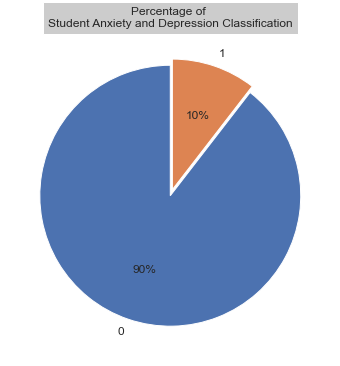

In [20]:
# Percentage of Classification of Student Anexiety and Depression
labels = [0,1]
sizes = [6240, 730]

plt.figure(figsize=(20, 6))

plt.pie(sizes, labels = labels, textprops={'fontsize': 12}, startangle=90, 
       autopct='%1.0f%%',  explode=[0, 0.05])
plt.title("Percentage of \n" + "Student Anxiety and Depression Classification", 
          bbox={'facecolor':'0.8', 'pad':5})



In [21]:
# Get new column:'Total Words' 
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

# Get new column: 'Total Chars'
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)

In [22]:
data.sample(3)

,text,label,Total Words,Total Chars
2367,"Because of these certain people, the governmen...",0.0,23,118
456,Have you ever been... you're honest but you're...,1.0,13,60
106,"Every time after sunset, why must this heart b...",1.0,35,151


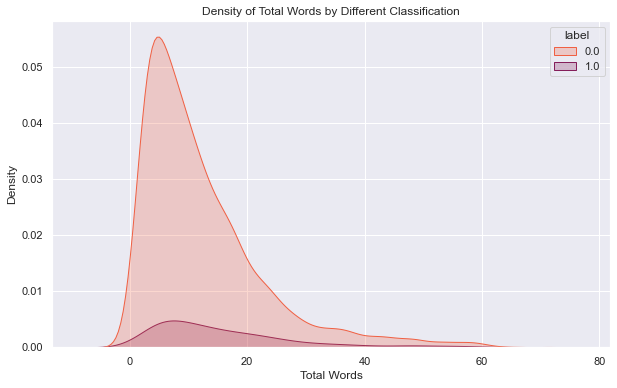

In [23]:
plt.figure(figsize = (10, 6))

sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'rocket_r',
             shade = True).set(title="Density of Total Words by Different Classification")
plt.show()

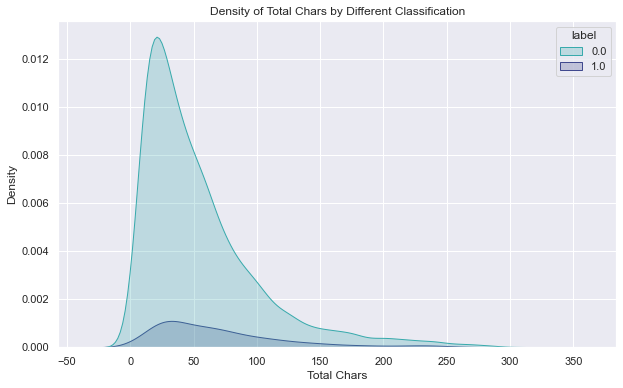

In [24]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'mako_r', 
            shade = True).set(title="Density of Total Chars by Different Classification")
plt.show()

In [25]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

In [26]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

In [27]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

In [29]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

In [30]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

In [31]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [32]:
data.sample(3)

,text,label,Total Words,Total Chars,Total Words After Transformation
1917,someon get foliooooo,0.0,3,20,1.098612
4329,dont take pocket lebaran gaesss alreadi finger...,0.0,31,160,2.833213
4973,raya mood kick,0.0,5,19,1.098612


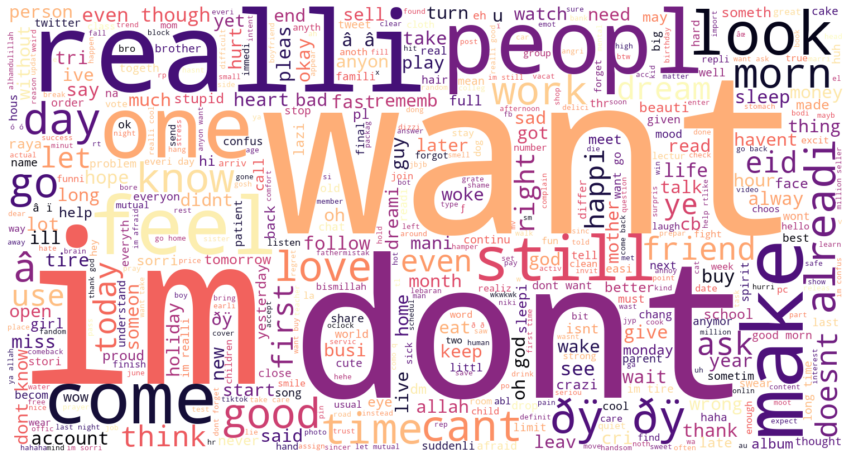

In [33]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="white", colormap= 'magma').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

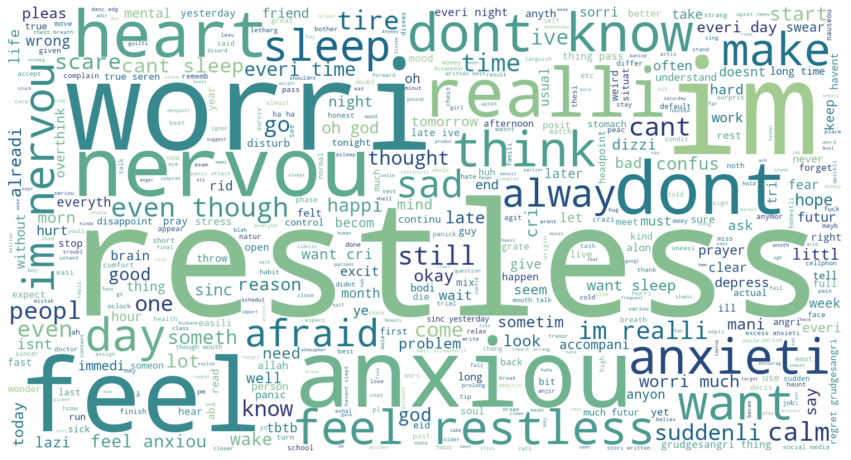

In [34]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="white", colormap= 'crest').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

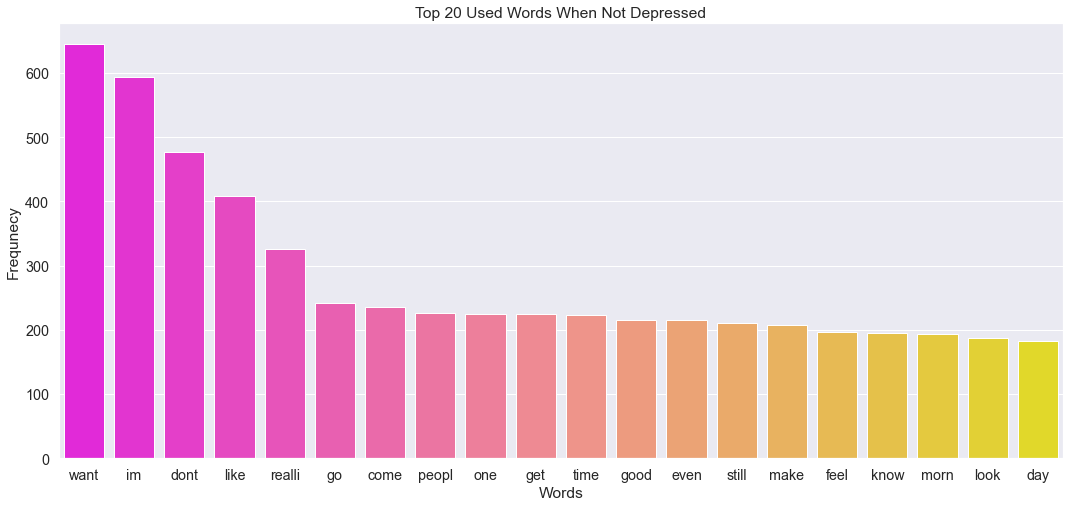

In [35]:
all_nodep_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_nodep_words.append(word)

df = pd.DataFrame(Counter(all_nodep_words).most_common(20), columns= ['Frequency','Word'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'spring')
plt.title("Top 20 Used Words When Not Depressed")
plt.xlabel("Words")
plt.ylabel("Frequnecy")
plt.show()

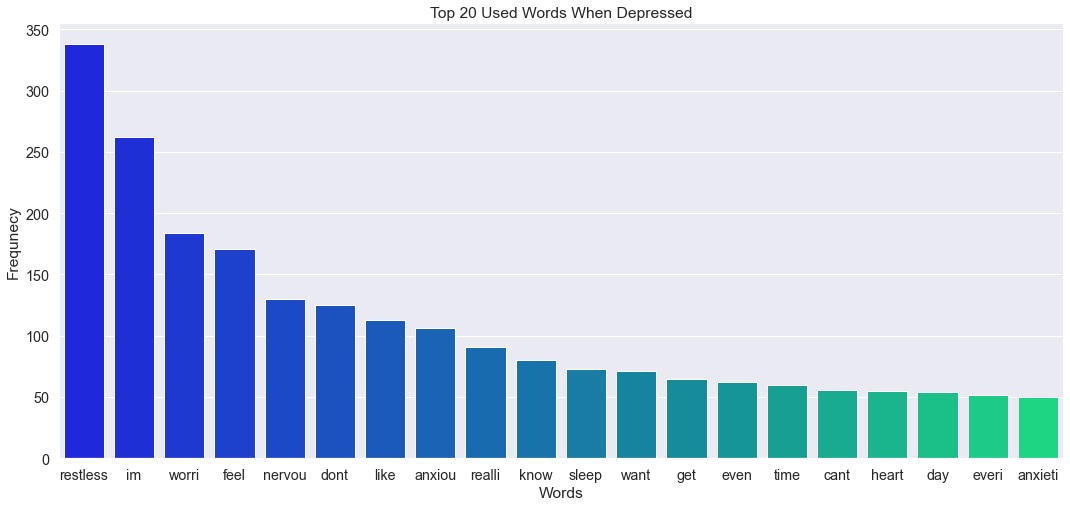

In [36]:
all_dep_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_dep_words.append(word)

df = pd.DataFrame(Counter(all_dep_words).most_common(20), columns= ['Frequency', 'Word'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'winter')
plt.title("Top 20 Used Words When Depressed")
plt.xlabel("Words")
plt.ylabel("Frequnecy")
plt.show()

In [37]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [38]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [39]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

Accuracy of the model: 0.934
Precision Score of the model: 1.0
Recall Score of the model: 0.37


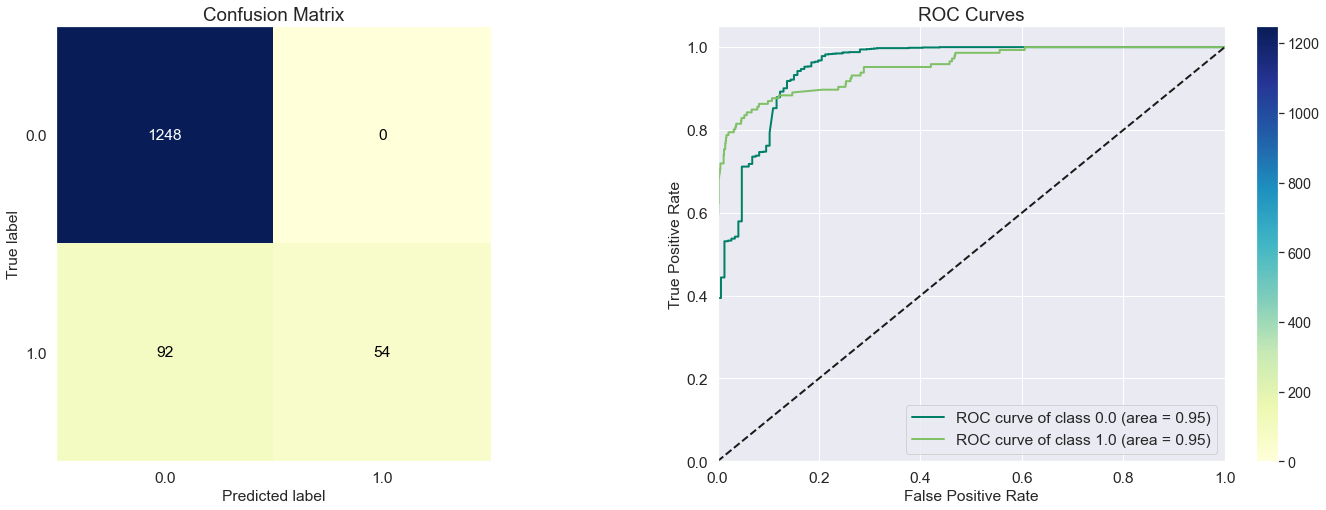

In [40]:
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.991
Precision Score of the model: 0.979
Recall Score of the model: 0.938


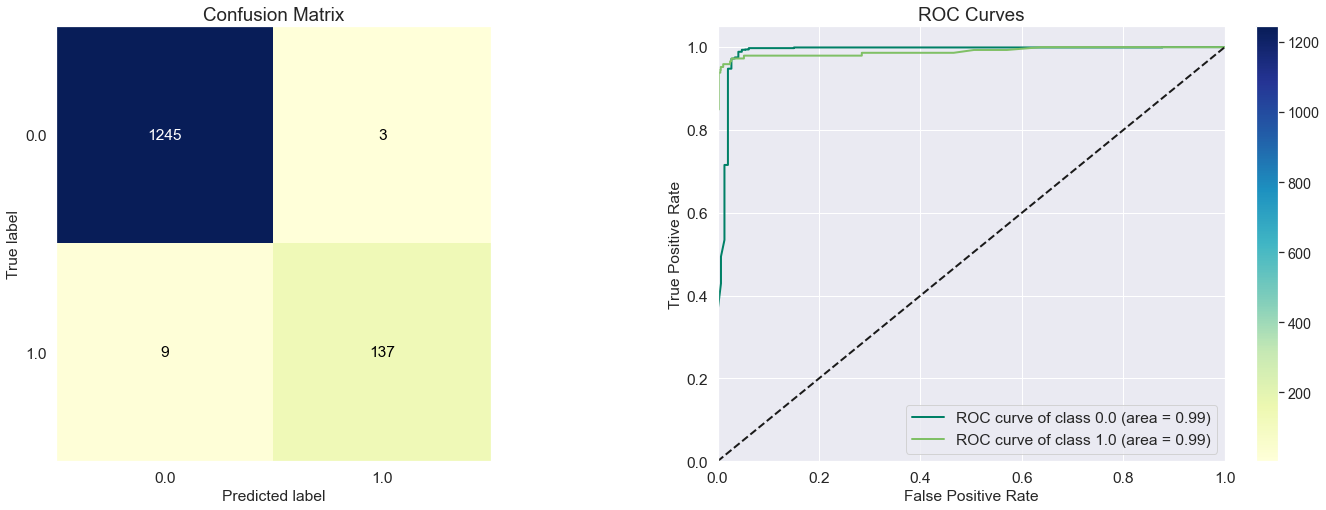

In [41]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

Accuracy of the model: 0.992
Precision Score of the model: 0.986
Recall Score of the model: 0.938


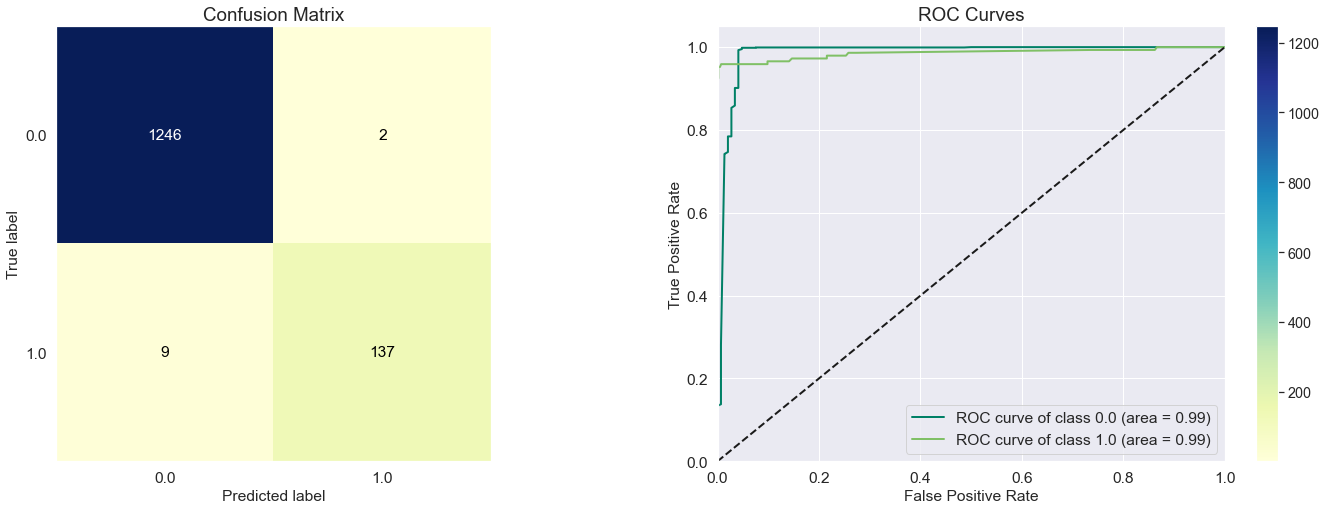

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
train_model(xgb)